In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import importlib
from PIL import Image
import pickle as pkl
import json
import gseapy as gp
import matplotlib.pyplot as plt
from gseapy import barplot, dotplot
gsea_dir = '/home/chrissy1/spatial/stomics/ovary_froz/redo/seurat/bin50_processed/annot_celltype_ind_analysis'


## DEG dotplot

In [4]:
celltype = 'ENDO_SM(CLDN5)'
adata = sc.read_h5ad(os.path.join(gsea_dir, celltype, 'SCT.h5ad'))

In [3]:
adata.obs[['batch', 'leiden']].value_counts().sort_index()

batch  leiden
Fresh  0         1338
       1          571
       2          440
       3          536
       4          606
       5          429
       6            7
Slow   0          804
       1          603
       2          530
       3          511
       4          402
       5          250
       6           63
Vitri  0          689
       1          523
       2          395
       3          254
       4          263
       5          162
       6           46
Name: count, dtype: int64

/home/chrissy1/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:811: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


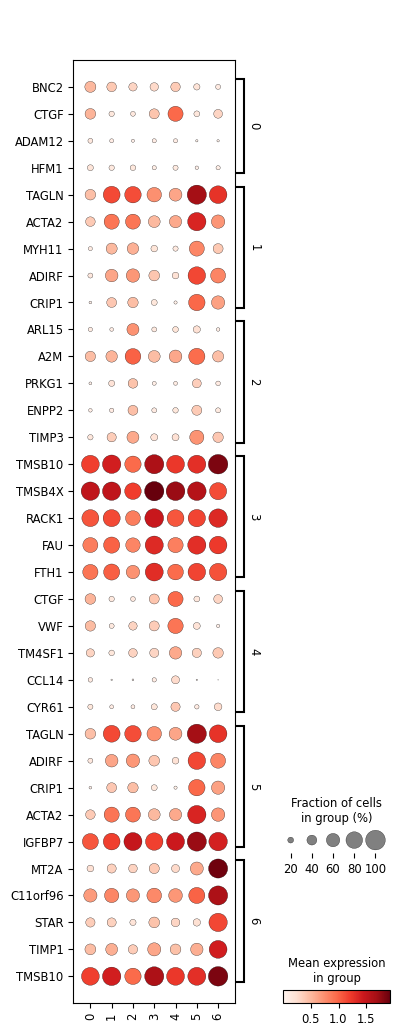

In [5]:
mks = pd.read_csv(os.path.join(gsea_dir, celltype, 'leiden_markers.csv'), index_col=0)
mks = mks[~mks['names'].str.contains('RPS|RPL|MT-|MALAT')]
mks = mks[(mks['pvals_adj']<0.05)&(mks['pct_nz_group']>0.15)&(mks['logfoldchanges']>0.6)].sort_values('group')
mks_dict = {str(grp): mks[mks['group']==grp].sort_values('pvals_adj', ascending=True)['names'][:5] for grp in mks['group'].unique()}
sc.pl.dotplot(adata, mks_dict, groupby='leiden', dendrogram=False, use_raw=False, swap_axes=True, var_group_rotation=0)

/home/chrissy1/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:811: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


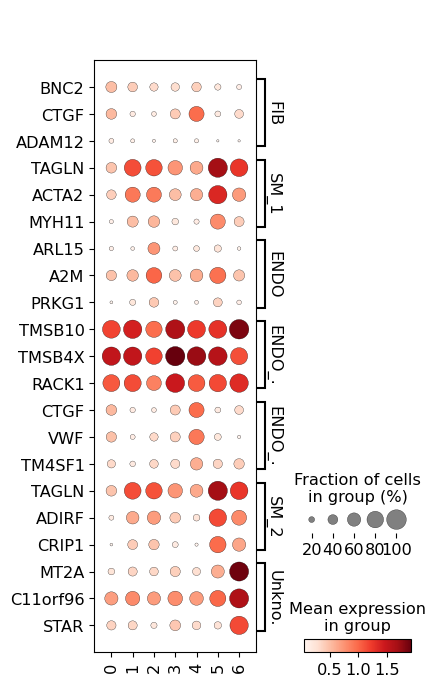

In [6]:
annotation_dict = {
    '0': 'FIB',
    '1': 'SM_1',
    '2': 'ENDO',
    '3': 'ENDO_FIB_1',
    '4': 'ENDO_FIB_2',
    '5': 'SM_2',
    '6': 'Unknown',
}
plt.rcParams['font.size'] = 14
mks_dict = {annotation_dict[str(grp)]: mks[mks['group']==grp].sort_values('pvals_adj', ascending=True)['names'][:3] for grp in mks['group'].unique()}
sc.pl.dotplot(adata, mks_dict, groupby='leiden', dendrogram=False, use_raw=False, swap_axes=True, var_group_rotation=0, save='deg_leiden_annot.svg')


/home/chrissy1/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:811: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


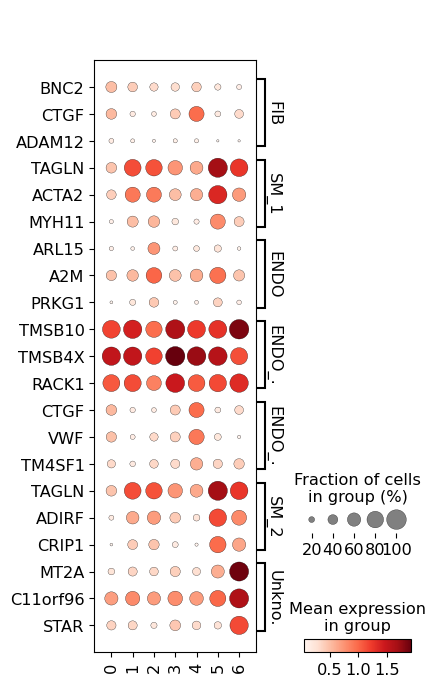

In [11]:
annot = {
    '0': 'FIB',
    '1': 'SM_1',
    '2': 'ENDO',
    '3': 'ENDO_FIB_1',
    '4': 'ENDO_FIB_2',
    '5': 'SM_2',
    '6': 'Unknown',
}
annot_dict = {annot[str(grp)]: mks[mks['group']==grp].sort_values('pvals_adj', ascending=True)['names'][:3] for grp in mks['group'].unique()}
sc.pl.dotplot(adata, annot_dict, groupby='leiden', dendrogram=False, use_raw=False, swap_axes=True, var_group_rotation=0, save='deg_leiden_annot.svg')

/home/chrissy1/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


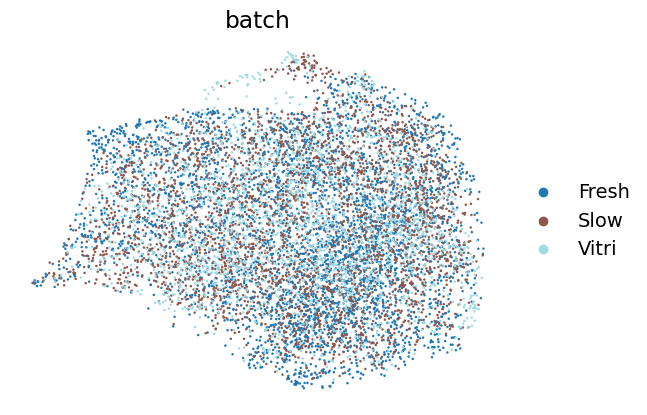

/home/chrissy1/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:401: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


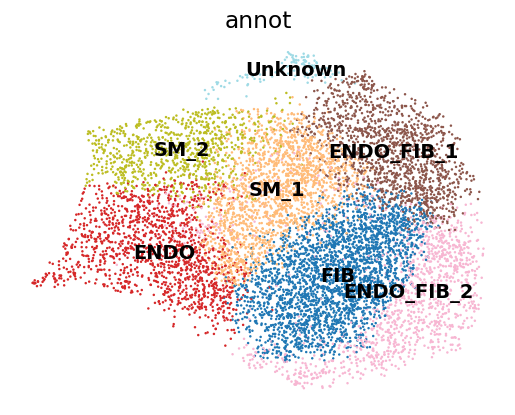

In [12]:
adata.obs['annot'] = adata.obs['leiden'].replace(annot)
sc.pl.umap(adata, color=['batch'], save='_batch.svg', frameon=False, palette='tab20')
sc.pl.umap(adata, color=['annot'], legend_loc='on data', save='_annot.svg', frameon=False, palette='tab20')

In [13]:
adata.write(os.path.join(gsea_dir, celltype, 'SCT.h5ad'))

## GSEA dotplot

In [2]:

for d in ['ENDO_SM(CLDN5)', 'O(PDCD5)']:
    d_dir = f'{gsea_dir}/{d}'
    reses = {}
    files = [f for f in os.listdir(f'{gsea_dir}/{d}') if f.endswith('.pkl')]
    for file in files:
        res = pkl.load(open(f'{gsea_dir}/{d}/{file}', 'rb')).res2d
        key = file.split('_')[0]
        res['comparison'] = key
        print(key)
        posres = res[(res['NES']>0)&(res['FDR q-val']<0.05)]
        posres = posres[~posres.Term.str.startswith('KEGG')]  # remove KEGG pathways 
        posres['Term'] = posres['Term'].values
        posres['Term'] = posres['Term'].str.split('__').str[1]
        posres['Term'] = posres['Term'].str.split('\(GO').str[0]
        posres['Term'] = posres['Term'].str.split(' R-').str[0]
        print(posres.shape)
        reses[key] = posres
    total_results = pd.concat(reses.values())
    print(total_results.comparison.value_counts())
    total_results = total_results.drop_duplicates()
    total_results.to_csv(f'{gsea_dir}/{d}_total_results.csv', index=False)


6
(524, 11)
2
(366, 11)


0
(0, 11)
4
(1357, 11)
3
(1844, 11)
1
(61, 11)
5
(1342, 11)
comparison
3    1844
4    1357
5    1342
6     524
2     366
1      61
Name: count, dtype: int64
2
(0, 11)
0
(2893, 11)
4
(1478, 11)
3
(0, 11)
1
(0, 11)
comparison
0    2893
4    1478
Name: count, dtype: int64


In [12]:
f = pkl.load(open(f'/home/chrissy1/spatial/stomics/ovary_froz/redo/seurat/bin50_processed/annot_celltype_ind_analysis/ENDO_SM(CLDN5)/0_res.pkl', 'rb')).res2d
f[(f['FDR q-val']<0.05)]

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,MSigDB_Hallmark_2020__Oxidative Phosphorylation,-0.770148,-3.991477,0.0,0.0,0.0,118/200,12.20%,NDUFA4;ATP5ME;COX6C;MGST3;COX7A2;COX4I1;COX7C;...
1,gsea,Reactome_2022__Translation R-HSA-72766,-0.799803,-3.916349,0.0,0.0,0.0,130/261,5.57%,RPL37A;RPS27;RPS14;RPL41;RPS23;RPL34;RPS19;RPL...
2,gsea,Reactome_2022__Signaling By ROBO Receptors R-H...,-0.826787,-3.887933,0.0,0.0,0.0,109/204,5.58%,RPL37A;RPS27;RPS14;RPL41;RPS23;RPL34;RPS19;RPL...
3,gsea,"Reactome_2022__Respiratory Electron Transport,...",-0.83914,-3.880843,0.0,0.0,0.0,72/111,7.69%,ATP5ME;COX6C;NDUFA13;COX4I1;COX7C;UQCRB;UQCR11...
4,gsea,Reactome_2022__rRNA Processing R-HSA-72312,-0.824236,-3.861626,0.0,0.0,0.0,81/196,3.62%,RPL37A;RPS27;RPS14;RPL41;RPS23;RPL34;RPS19;RPL...
...,...,...,...,...,...,...,...,...,...,...
1950,gsea,Reactome_2022__Signaling By Retinoic Acid R-HS...,-0.411528,-1.533981,0.030303,0.049501,1.0,18/36,40.18%,PDK2;CYP26B1;RARB;RARG;DHRS3;CPT1A;DHRS4;ALDH1...
1951,gsea,GO_Biological_Process_2023__Lipid Droplet Orga...,-0.428097,-1.533619,0.042339,0.049595,1.0,7/27,15.56%,PPIA;PNPLA2;CDS2;PPID;CIDEB;FITM1;PLIN5
1952,gsea,Reactome_2022__Inflammasomes R-HSA-622312,-0.457391,-1.533604,0.048,0.049574,1.0,14/21,43.47%,TXNIP;APP;NLRP1;BCL2L1;NFKB2;PSTPIP1;PYCARD;CA...
1953,gsea,Reactome_2022__G-protein Mediated Events R-HSA...,-0.358224,-1.532948,0.024887,0.049798,1.0,21/51,43.41%,PDE1A;CALM1;ADCY5;CAMK2G;GRK2;NBEA;PRKAR1A;PDE...


In [14]:
comp = 'ENDO_SM(CLDN5)'
total_results = pd.read_csv(f'{gsea_dir}/{comp}_total_results.csv')
total_results = total_results[~total_results['Term'].str.contains('Viral|Disease|Defective|HIV')]
lgs = [','.join(x.split(';')[:3]) for x in total_results['Lead_genes']]
total_results['Term'] = [f'{x}_({lgs[i]})' for i,x in enumerate(total_results['Term'])]
total_results['comparison'] = [annot[str(x)] for x in total_results['comparison']]
ax = dotplot(total_results,
            column="FDR q-val",
            x='comparison', # set x axis, so you could do a multi-sample/library comparsion
            size=3,
            top_term=5,
            figsize=(8,12),
            xticklabels_rot=45, # rotate xtick labels
            show_ring=True, # set to False to revmove outer ring
            marker='o', 
            cutoff=0.01,
            title=comp,
            ofname=f'figures/gseapy_dotplot_cross_sample.svg'
            )

/home/chrissy1/.conda/envs/scanpy_env/lib/python3.9/site-packages/gseapy/plot.py:602: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(


In [17]:
adata.obs[['batch', 'annot']].value_counts().sort_index()	

batch  annot     
Fresh  FIB           1338
       SM_1           571
       ENDO           440
       ENDO_FIB_1     536
       ENDO_FIB_2     606
       SM_2           429
       Unknown          7
Slow   FIB            804
       SM_1           603
       ENDO           530
       ENDO_FIB_1     511
       ENDO_FIB_2     402
       SM_2           250
       Unknown         63
Vitri  FIB            689
       SM_1           523
       ENDO           395
       ENDO_FIB_1     254
       ENDO_FIB_2     263
       SM_2           162
       Unknown         46
Name: count, dtype: int64